In [76]:
%pip install pyspark

In [77]:
import pandas as pd
import numpy as np
!pip install nbformat 
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as make_subplots
from plotly.subplots import make_subplots
import statistics as stats

# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *
from pyspark.sql.types import ArrayType, TimestampType, FloatType, IntegerType
from datetime import datetime, timedelta

import seaborn as sns
from pyspark.ml.classification import RandomForestClassificationModel
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [78]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("endomondoHR") \
        .getOrCreate()
    return spark

spark = init_spark()


In [79]:
filename_data = 'endomondoHR.json'
df = spark.read.json(filename_data, mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


# Dataset Overview

In [80]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- altitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- gender: string (nullable = true)
 |-- heart_rate: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- id: long (nullable = true)
 |-- latitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- longitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- speed: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- sport: string (nullable = true)
 |-- timestamp: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- url: string (nullable = true)
 |-- userId: long (nullable = true)

Columns overview


,Column Name,Data type
0,altitude,array<double>
1,gender,string
2,heart_rate,array<bigint>
3,id,bigint
4,latitude,array<double>
5,longitude,array<double>
6,speed,array<double>
7,sport,string
8,timestamp,array<bigint>
9,url,string


In [81]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

Data frame describe (string and numeric columns only):


,summary,gender,id,sport,url,userId
0,count,253020,253020,253020,253020,253020
1,mean,None,3.566244412926132E8,None,None,4619648.939783417
2,stddev,None,1.574845634895318E8,None,None,3932877.7296880507
3,min,female,99296,aerobics,https://www.endomondo.com/users/10014612/worko...,69
4,max,unknown,674008008,yoga,https://www.endomondo.com/users/9991401/workou...,15481421


In [82]:
print(f'There are total {df.count()} row, Let print first 2 data rows:')
df.limit(2).toPandas()

There are total 253020 row, Let print first 2 data rows:


,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,"[60.173247596248984, 60.17320962622762, 60.172...","[24.649855233728886, 24.65015547350049, 24.650...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915


In [83]:
# Definisikan kolom string, numerik, dan array
string_columns = ['gender', 'sport', 'url']
numeric_columns = ['id', 'userId']
array_columns = ['altitude', 'heart_rate', 'latitude', 'longitude', 'speed', 'timestamp']

# Dictionary untuk menyimpan hasil missing value
missing_values = {}

# Loop melalui setiap kolom dan cek missing value
for column in df.columns:
    if column in string_columns:  # Cek kolom string untuk nilai None atau Null
        missing_count = df.filter(col(column).isNull() | col(column).eqNullSafe(None)).count()
    elif column in numeric_columns:  # Cek kolom numerik untuk nilai 0, None, atau NaN
        missing_count = df.filter(col(column).isin([0, None, np.nan])).count()
    elif column in array_columns:  # Cek kolom array untuk nilai 0 atau NaN di dalam array
        missing_count = df.filter(array_contains(col(column), 0) | array_contains(col(column), np.nan)).count()
    
    # Tambahkan hasilnya ke dictionary
    missing_values[column] = missing_count

# Konversi dictionary ke DataFrame pandas
missing_df = pd.DataFrame(list(missing_values.items()), columns=['Column', 'Missing Values'])

# Tampilkan hasil
missing_df


,Column,Missing Values
0,altitude,40848
1,gender,0
2,heart_rate,1280
3,id,0
4,latitude,113
5,longitude,113
6,speed,7741
7,sport,0
8,timestamp,0
9,url,0


# EDA

In [84]:
# Register the DataFrame as a temporary view
df.createOrReplaceTempView("sports_data")

# Run SQL query to get the top sports with users count
sport_users_df = spark.sql("""
    SELECT sport, COUNT(DISTINCT userId) AS `Users count`
    FROM sports_data
    GROUP BY sport
    ORDER BY `Users count` DESC
""")

# Convert to Pandas DataFrame
sport_users_df = sport_users_df.toPandas()

# Calculate the total users
total_sports_users = spark.sql("""
    SELECT SUM(`Users count`) 
    FROM (SELECT sport, COUNT(DISTINCT userId) AS `Users count`
          FROM sports_data
          GROUP BY sport)
""").collect()[0][0]

# Run SQL query
sport_users_df_with_percentage = spark.sql(f"""
    SELECT sport, 
           COUNT(DISTINCT userId) AS `Users count`,
           (COUNT(DISTINCT userId) / {total_sports_users} * 100) AS percentage
    FROM sports_data
    GROUP BY sport
    ORDER BY `Users count` DESC
""")

# Convert to Pandas DataFrame for further use
sport_users_df_with_percentage = sport_users_df_with_percentage.toPandas()

# Display the result
print(sport_users_df_with_percentage)


                      sport  Users count  percentage
0                       run          865   25.130738
1                      bike          794   23.067984
2             mountain bike          336    9.761766
3          bike (transport)          252    7.321325
4                      walk          209    6.072051
5   core stability training          183    5.316676
6            indoor cycling          180    5.229518
7                    hiking           92    2.672865
8      cross-country skiing           70    2.033701
9           fitness walking           48    1.394538
10             orienteering           44    1.278327
11          weight training           39    1.133062
12                    skate           33    0.958745
13         circuit training           31    0.900639
14          downhill skiing           29    0.842533
15               elliptical           26    0.755375
16                 kayaking           21    0.610110
17        treadmill running           20    0.

In [85]:
# Sort the dataframe by Users count in descending order
df_sorted = sport_users_df_with_percentage.sort_values('Users count', ascending=False)

# Create subplot with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add bars for Users count
fig.add_trace(
    go.Bar(x=df_sorted['sport'], y=df_sorted['Users count'], name="Users count"),
    secondary_y=False,
)

# Add line for percentage
fig.add_trace(
    go.Scatter(x=df_sorted['sport'], y=df_sorted['percentage'], name="Percentage", mode='lines+markers'),
    secondary_y=True,
)

# Update layout
fig.update_layout(
    title_text="Sports Popularity",
    xaxis_title="Sport",
    barmode='group',
    height=600,
    width=1400,
)

# Set y-axes titles
fig.update_yaxes(title_text="Users Count", secondary_y=False)
fig.update_yaxes(title_text="Percentage", secondary_y=True)

# Show the plot
fig.show()


* Running and biking are the clear leaders in terms of sports popularity, followed by activities like mountain biking, walking, and core stability training.
* While there is a broad array of activities, the engagement significantly drops after the top five, indicating a concentration of users in a few select sports.
* Niche sports (e.g., scuba diving, wheelchair sports) have limited participation, suggesting either specialized interest or availability.

In [86]:
top_5_df = sport_users_df_with_percentage.nlargest(5, 'Users count')  # Ambil 5 data teratas
others_df = sport_users_df_with_percentage.iloc[5:].copy()  # Data selain 5 teratas

# Hitung total pengguna dan persentase untuk kategori 'others'
others_count = others_df['Users count'].sum()
others_percentage = others_df['percentage'].sum()

# Buat baris 'others'
others_row = pd.DataFrame({
    'sport': ['others'],
    'Users count': [others_count],
    'percentage': [others_percentage]
})

# Gabungkan 5 teratas dengan 'others'
top5_sport_final = pd.concat([top_5_df, others_row], ignore_index=True)

# Tampilkan hasil
print(top5_sport_final)


              sport  Users count  percentage
0               run          865   25.130738
1              bike          794   23.067984
2     mountain bike          336    9.761766
3  bike (transport)          252    7.321325
4              walk          209    6.072051
5            others          986   28.646136


In [87]:
import plotly.express as px

# Bar Chart
fig_bar = px.bar(
    top5_sport_final,
    x='sport',
    y='Users count',
    title='Top 5 Sports',
    labels={'Users count': 'Users Count', 'sport': 'Sport'},
    text='Users count'
)
fig_bar.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig_bar.update_layout(yaxis_title="Users Count", xaxis_title="Sport", showlegend=False)
fig_bar.show()

# Pie Chart
fig_pie = px.pie(
    top5_sport_final,
    names='sport',
    values='Users count',
    title='Top 5 Sports',
    hole=0.3
)
fig_pie.update_traces(textinfo='percent+label')
fig_pie.show()


In [101]:

unique_users_df = df.select("userId", "gender").distinct()
gender_counts_df = unique_users_df.groupBy("gender").count().toPandas()
gender_counts_df.rename(columns={'count': 'Users count'}, inplace=True)


In [102]:
gender_counts_df

,gender,Users count
0,unknown,15
1,female,110
2,male,979


Based on the existing data, it turns out that the most users are Male with 979 people, Female with 110, and unknown as many as 15.

In [88]:
activities_by_gender = df.groupBy('sport', 'gender').count().toPandas()

In [89]:
print(activities_by_gender)

                      sport  gender   count
0                    hiking  female      71
1   core stability training    male    1103
2                       run    male  107882
3                  kayaking    male     253
4             mountain bike    male   12782
..                      ...     ...     ...
85               wheelchair    male       1
86                    rugby    male       7
87              windsurfing    male       1
88         beach volleyball    male       2
89            skateboarding    male       1

[90 rows x 3 columns]


C:\Users\N7400PC\AppData\Local\Temp\ipykernel_18200\967256225.py:6: FutureWarning:

The provided callable <function mean at 0x0000025AB6D2FE20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.



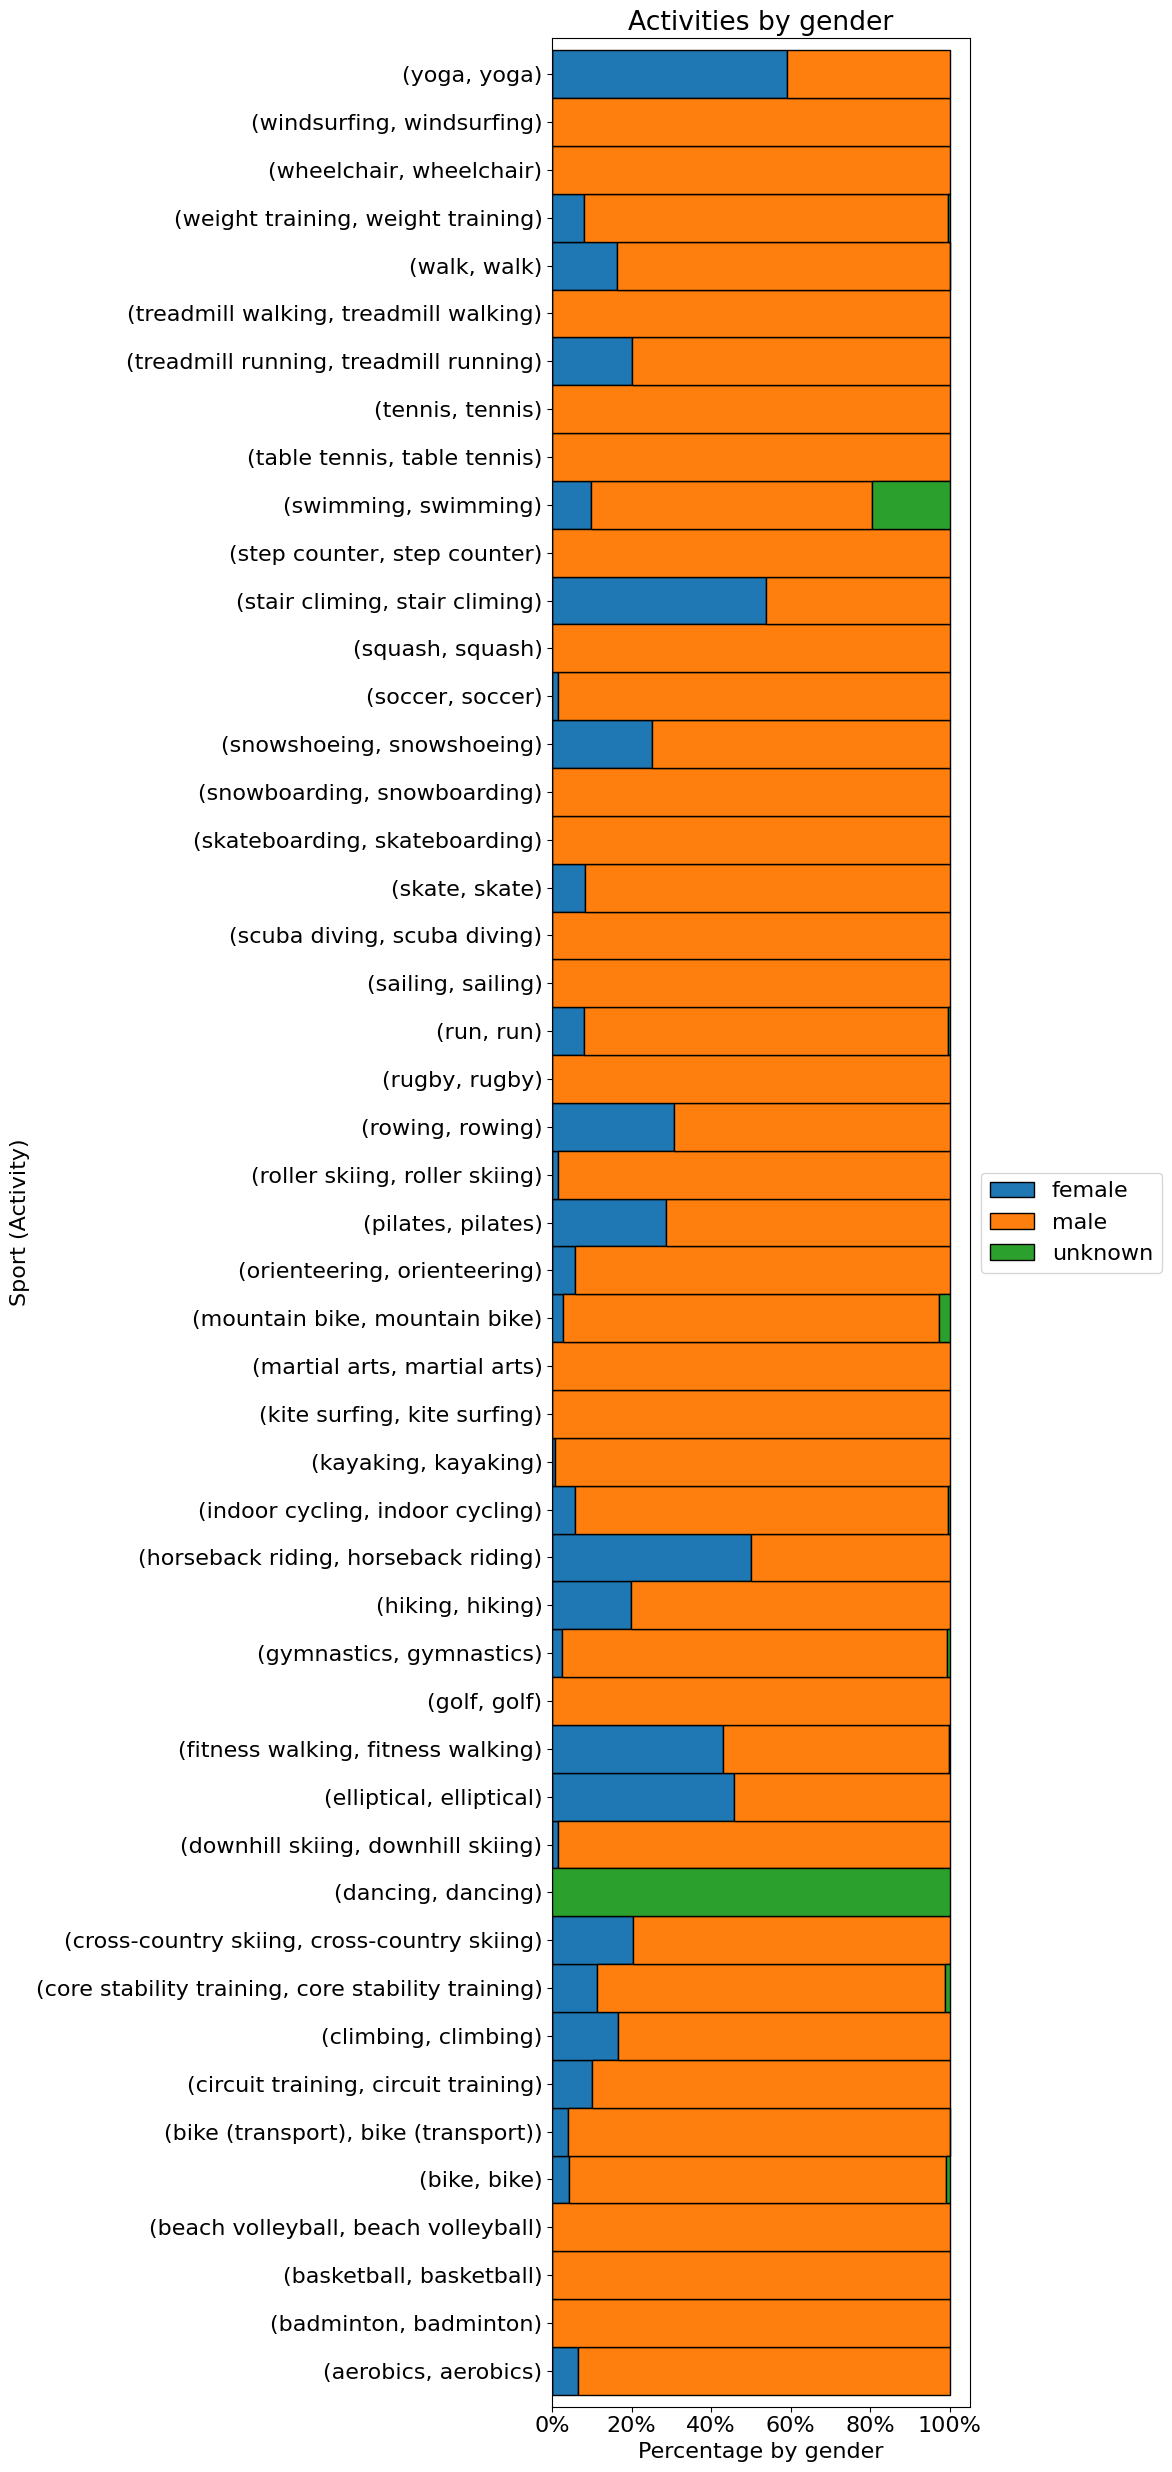

In [90]:
activities_by_gender = df.groupBy('sport', 'gender').count().toPandas()

fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = activities_by_gender.groupby(['sport', 'gender']).agg(np.mean).groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', stacked=True, width=1
                , edgecolor='black', ax=ax, title='Activities by gender')
ylabel = plt.ylabel('Sport (Activity)');
xlabel = plt.xlabel('Percentage by gender');
legend = plt.legend(
    sorted(activities_by_gender['gender'].unique()), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

almost all activities are dominated by male, except yoga which is dominated by female.

In [91]:
def to_time(timestamp_list):
    # convert to datetime and minus 7 hours due to the difference in Endomondo time window with utc time as the dataset description
    return [datetime.fromtimestamp(t) - timedelta(hours=7) for t in timestamp_list]

# Register 'to_time' function into UDF pyspark framework
udf_to_time = udf(to_time, ArrayType(elementType=TimestampType()))

# Support function to get the duration (in minutes) of a list of datetime values, to be used for withColumn function later
def get_duration(datetime_list):
    time_dif = max(datetime_list) - min(datetime_list)
    return time_dif.seconds/60

# Register the support function 'get_duration' as a user defined function into pyspark framework
udf_get_duration = udf(get_duration, FloatType())

# Support function to get the workout start time of the datetime list, to be used for withColumn function later
def get_start_time(datetime_list):
    return min(datetime_list)

# Register the support function 'get_start_time' as a user defined function into pyspark framework
udf_get_start_time = udf(get_start_time, TimestampType())

# Support function to get list of intervals within a workout
def get_interval(datetime_list):
    if len(datetime_list) == 1:
        return [0]
    else:
        interval_list = []
        for i in range(0, len(datetime_list)-1):
            interval = (datetime_list[i+1] - datetime_list[i]).seconds
            interval_list.append(interval)
        return interval_list

# Register the support function 'get_interval' as a user defined function into pyspark framework    
udf_get_interval = udf(get_interval, ArrayType(elementType=IntegerType()))

# Create new 'date_time' column to convert from timestamp into python's datetime format for later usage
df = df.withColumn('date_time', 
    udf_to_time('timestamp'))

# Create 'workout_start_time' column to get the start time of each workout/row:
df = df.withColumn('workout_start_time', hour(udf_get_start_time('date_time')))

# Create duration column from the date_time column just created, using the udf function udf_get_duration defined above
df = df.withColumn('duration', udf_get_duration('date_time'))

# Create interval column from the date_time column, using the udf function udf_get_interval defined above
df = df.withColumn('interval', udf_get_interval('date_time'))

print('New columns (''date_time'', ''workout_start_time'' in hour\
, ''duration'' in minutes & ''interval'' in seconds)\n, first 5 rows:')
df.select('timestamp','date_time', 'workout_start_time', 'duration', 'interval').limit(5).toPandas()

New columns (date_time, workout_start_time in hour, duration in minutes & interval in seconds)
, first 5 rows:


,timestamp,date_time,workout_start_time,duration,interval
0,"[1408898746, 1408898754, 1408898765, 140889877...","[2014-08-24 16:45:46, 2014-08-24 16:45:54, 201...",16,126.483330,"[8, 11, 13, 16, 6, 23, 16, 23, 29, 23, 24, 24,..."
1,"[1408221682, 1408221687, 1408221699, 140822170...","[2014-08-16 20:41:22, 2014-08-16 20:41:27, 201...",20,74.000000,"[5, 12, 8, 4, 5, 6, 4, 4, 5, 13, 7, 17, 4, 10,..."
2,"[1407858459, 1407858466, 1407858478, 140785849...","[2014-08-12 15:47:39, 2014-08-12 15:47:46, 201...",15,112.483330,"[7, 12, 12, 16, 6, 7, 16, 11, 19, 13, 17, 11, ..."
3,"[1407432042, 1407432048, 1407432056, 140743206...","[2014-08-07 17:20:42, 2014-08-07 17:20:48, 201...",17,75.316666,"[6, 8, 9, 4, 13, 4, 3, 4, 13, 10, 13, 13, 7, 1..."
4,"[1406909434, 1406909436, 1406909437, 140690943...","[2014-08-01 16:10:34, 2014-08-01 16:10:36, 201...",16,22.616667,"[2, 1, 1, 3, 2, 1, 4, 2, 1, 2, 1, 1, 2, 4, 4, ..."



Plotting distribution of duration per sport type:


C:\Users\N7400PC\AppData\Local\Temp\ipykernel_18200\1110209781.py:9: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared.



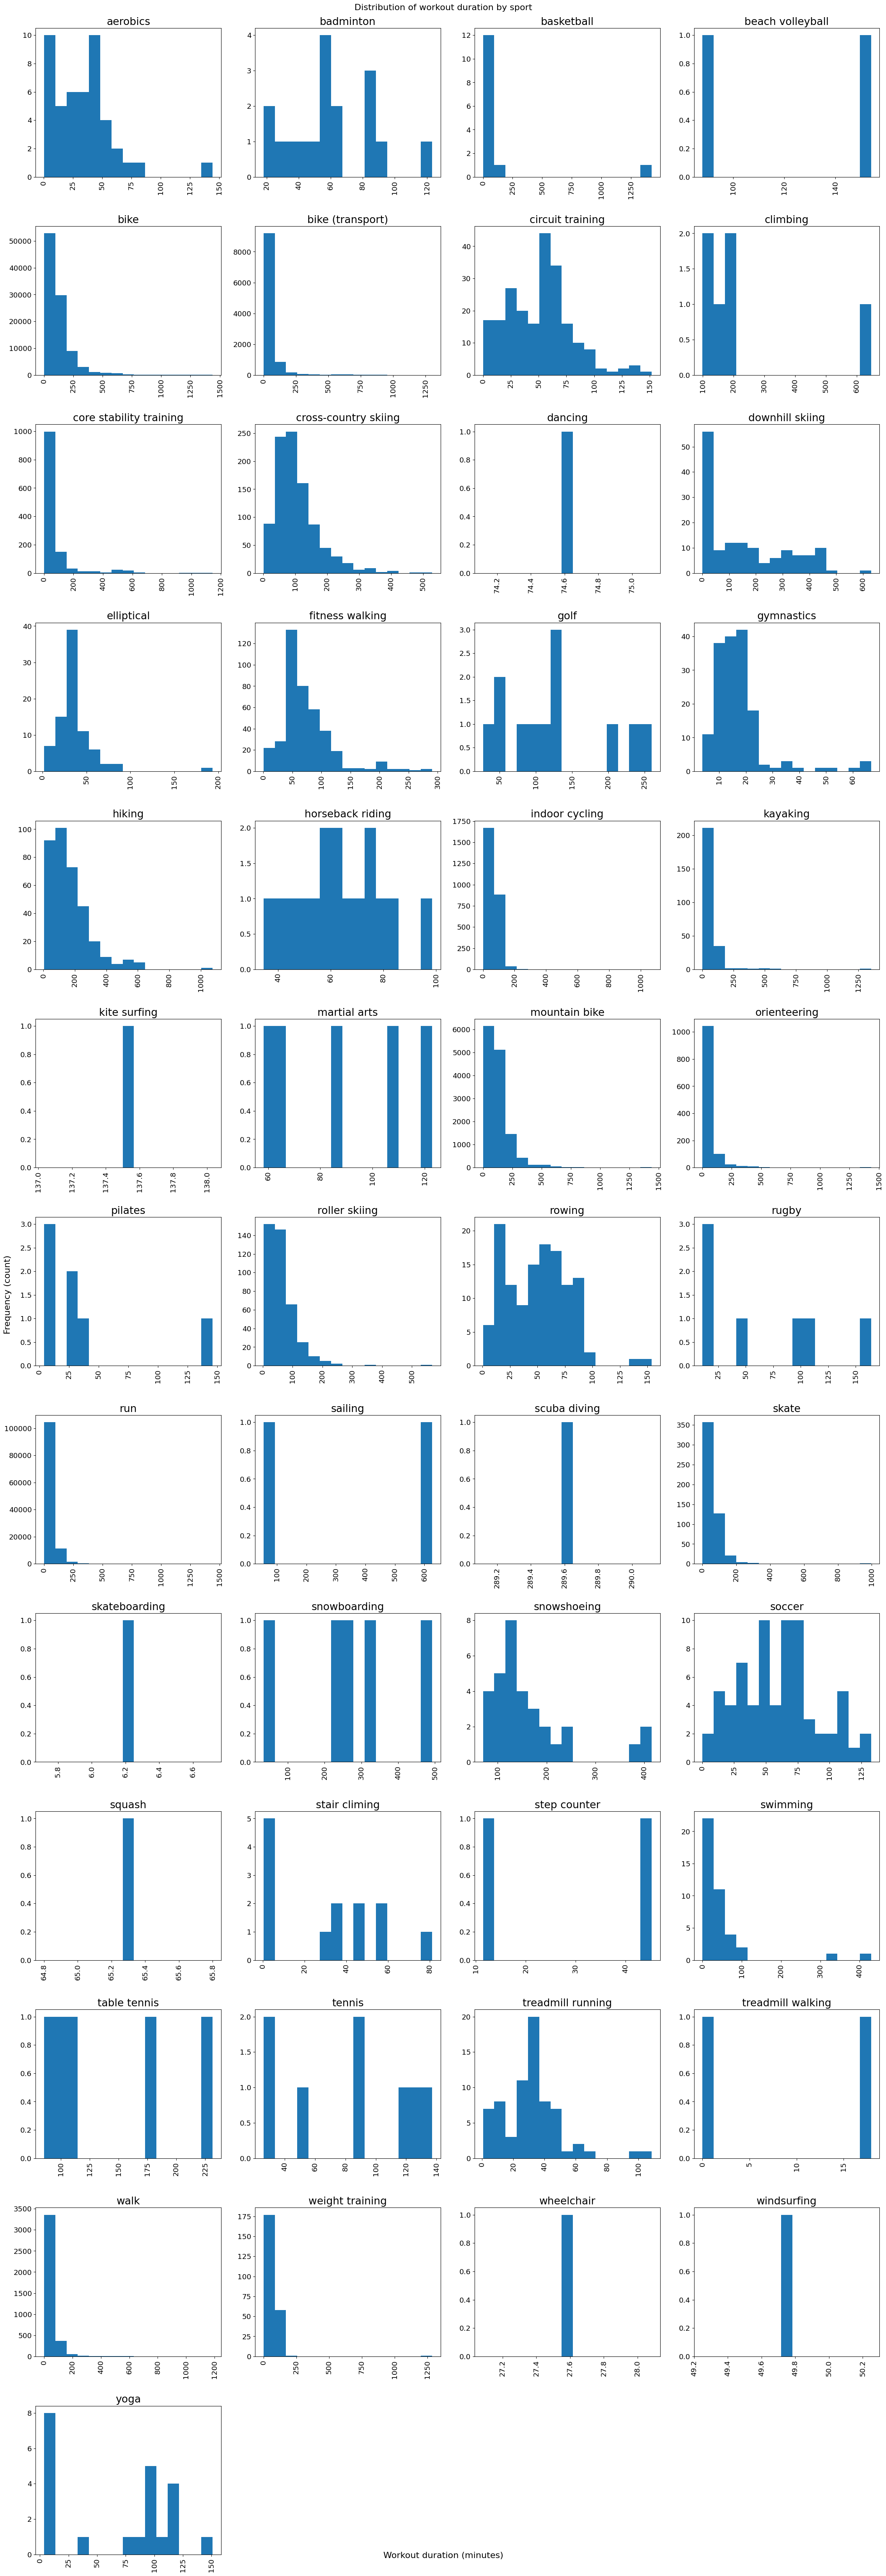

In [92]:
print('\nPlotting distribution of duration per sport type:')
plot_size_x, plot_size_y = 5, 5#
figsize_x, figsize_y = plot_size_x * 4 +3, plot_size_y * 13 + 1
figsize = (figsize_x, figsize_y)
fig = plt.figure(figsize=figsize) #
grid_size = (13,4)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)

duration_dist = df.select('duration', 'sport').toPandas().hist(
    column='duration', by='sport', bins=15, sharex = False, grid=True
    , xlabelsize='small', ylabelsize='small' , ax = ax
    , layout = grid_size, figsize=figsize
    )
a = fig.tight_layout()
title = fig.text(0.5, 1, 'Distribution of workout duration by sport'
             , ha='center', va='center', transform=fig.transFigure
            )
xlabel = fig.text(0.5, 0.01, 'Workout duration (minutes)'
             , ha='center', va='center', transform=fig.transFigure)
ylabel = fig.text(0.01, 0.5, 'Frequency (count)', va='center', rotation='vertical');

In [93]:
# the stats to calculate is also given as an input
def calculate_stats(x,column_name, stat_list):
    sport, records_list = x
    stat_dict = {'sport': sport}
    if 'min' in stat_list:
        min_stat = min(records_list)
        stat_dict.update({'min ' + column_name : min_stat})
    if 'max' in stat_list:
        max_stat = max(records_list)
        stat_dict.update({'max ' + column_name: max_stat})
    if 'mean' in stat_list:
        average_stat = stats.mean(records_list)
        stat_dict.update({'mean ' + column_name: average_stat})
    if 'stdev' in stat_list:
        std_stat = stats.stdev(records_list)
        stat_dict.update({'stdev ' + column_name: std_stat})
    if '50th percentile' in stat_list:
        median_stat = stats.median(records_list)
        stat_dict.update({'50th percentile ' + column_name: median_stat})
    if '25th percentile' in stat_list:
        percentile_25th_stat = np.percentile(records_list, 25)
        stat_dict.update({'25th percentile ' + column_name: percentile_25th_stat})
    if '75th percentile' in stat_list:
        percentile_75th_stat = np.percentile(records_list, 75)
        stat_dict.update({'75th percentile ' + column_name: percentile_75th_stat})
    if '95th percentile' in stat_list:
        percentile_95th_stat = np.percentile(records_list, 95)
        stat_dict.update({'95th percentile ' + column_name: percentile_95th_stat})
    return stat_dict

In [94]:
def to_list(a):
    return a

def extend(a, b):
    a.extend(b)
    return a

def retrieve_array_column_stat_df(df, column_name, stat_list):
    sport_record_rdd = df.select('sport', column_name).rdd \
    .map(tuple).combineByKey(to_list, extend, extend).persist()

    record_statistic_df = pd.DataFrame(sport_record_rdd.map(
        lambda x: calculate_stats(x, column_name,stat_list)).collect())
    columns_order = ['sport'] + [stat + ' ' + column_name for stat in stat_list]
    # Re order columns
    return record_statistic_df[columns_order]

stat_list = ['min', '25th percentile', 'mean', '50th percentile',
                     '75th percentile', '95th percentile', 'max', 'stdev']
interval_statistic_df = retrieve_array_column_stat_df(df, column_name='interval', stat_list=stat_list)
print('\nLet\'s look at statistic for interval, in seconds (by sport):' )
interval_statistic_df


Let's look at statistic for interval, in seconds (by sport):


,sport,min interval,25th percentile interval,mean interval,50th percentile interval,75th percentile interval,95th percentile interval,max interval,stdev interval
0,squash,2,6.0,7.851703,8.0,10.00,13.00,18,2.900293
1,circuit training,0,3.0,9.675286,5.0,9.00,24.00,6029,47.256595
2,climbing,3,14.0,30.470308,16.0,23.00,64.65,1318,69.604276
3,martial arts,0,6.0,13.563431,8.0,14.00,37.00,446,22.455242
4,cross-country skiing,0,6.0,15.107559,10.0,16.00,29.00,86399,426.429807
5,beach volleyball,0,12.0,59.516393,33.0,71.25,191.85,903,89.604732
6,soccer,0,4.0,7.579923,6.0,9.00,14.00,3584,33.544463
7,treadmill running,0,2.0,5.513624,4.0,6.00,13.00,683,10.635236
8,gymnastics,0,1.0,3.214098,2.0,3.00,8.00,2837,16.358282
9,dancing,2,20.0,72.209677,20.0,63.00,278.35,1178,159.687927


In [95]:
# Convert Spark DataFrame to Pandas DataFrame
start_time_df = df.select('gender', 'sport', 'workout_start_time').toPandas()

# Unique sport activities
activities = start_time_df['sport'].unique()


Plotting distribution of workout start time per sport type, breakdown by gender:


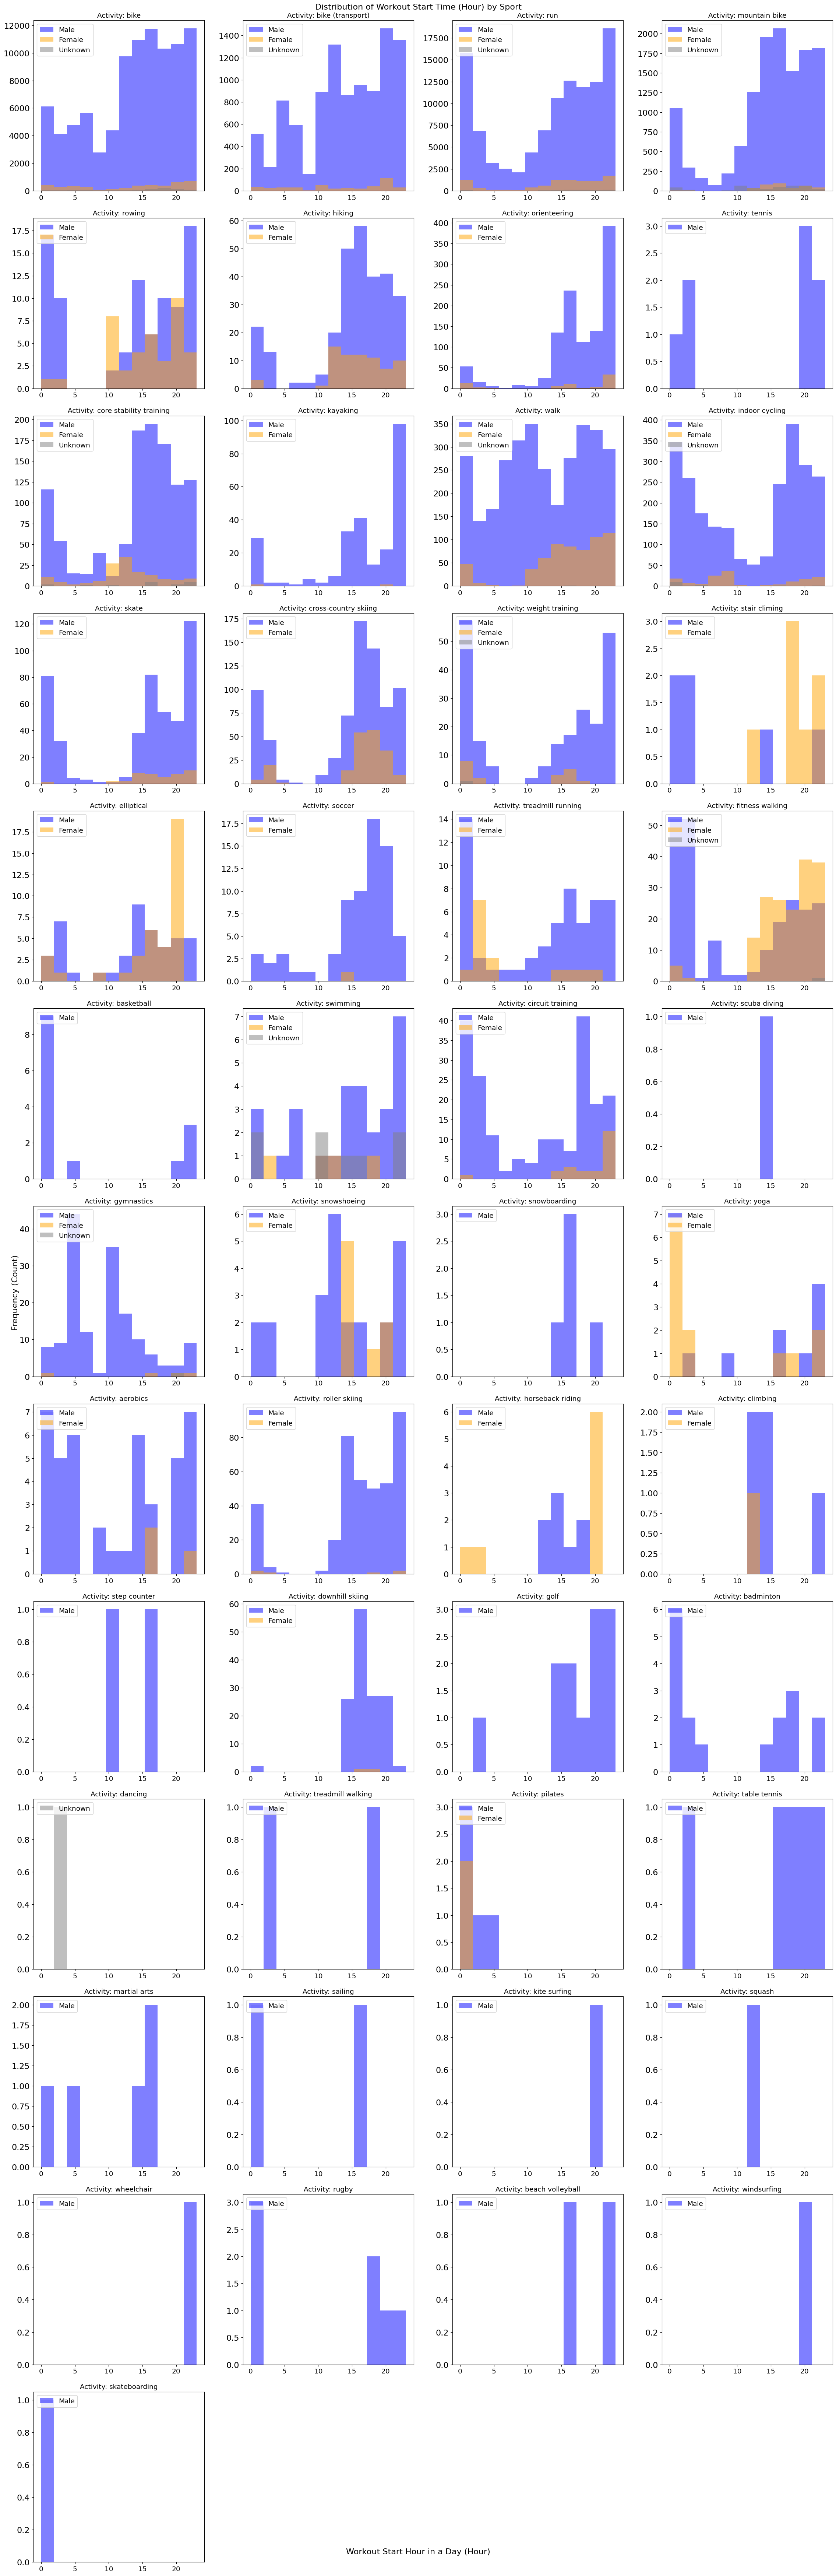

In [97]:
# Set plot sizes and subplots configuration
figsize_x, figsize_y = 23, 70
nrows, ncols = 13, 4

# Create figure and subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize_x, figsize_y))
fig.subplots_adjust(hspace=1, wspace=1)

print('\nPlotting distribution of workout start time per sport type, breakdown by gender:')

# Iterate through each unique sport
for index, sport in enumerate(activities):
    row_index, col_index = divmod(index, ncols)

    # Filter by sport and gender
    for gender, color, label in [('male', 'blue', 'Male'), ('female', 'orange', 'Female'), ('unknown', 'gray', 'Unknown')]:
        gender_data = start_time_df[(start_time_df['sport'] == sport) & (start_time_df['gender'] == gender)]['workout_start_time']
        if not gender_data.empty:
            axs[row_index, col_index].hist(gender_data, bins=12, alpha=0.5, label=label, range=(0, 23), color=color)

    # Set title and legend
    axs[row_index, col_index].set_title(f'Activity: {sport}', fontsize='small')
    axs[row_index, col_index].legend(loc="upper left", fontsize='small')
    axs[row_index, col_index].tick_params(axis='x', labelsize='small')

# Hide unused subplots
for i in range(1, ncols):
    axs[-1, i].set_visible(False)

# Set global labels and layout
fig.tight_layout()
fig.text(0.5, 1, 'Distribution of Workout Start Time (Hour) by Sport', ha='center', va='top', transform=fig.transFigure)
fig.text(0.5, 0.01, 'Workout Start Hour in a Day (Hour)', ha='center', va='bottom', transform=fig.transFigure)
fig.text(0.02, 0.5, 'Frequency (Count)', va='center', rotation='vertical')

plt.show()
